# 2. Cell Classifier
This note book is for classifying cells in the first BMC data set, annotated by Felicia.

In [1]:
import os
from pathlib import Path
import random
import numpy as np

import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

import keras
from keras.utils import Sequence
from keras.models import Model, load_model
from keras.layers import Input, multiply
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from weighted_loss_unet import make_weighted_loss_unet, my_loss

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import json
import pandas as pd

import utils
from weighted_loss_unet import make_weighted_loss_unet, my_loss
import config
c = config.Config()

## Investigating data

In [2]:
from dataset import Swebcg
df = Swebcg().get_dataframe()
df['class'].value_counts()
df['image_id']

0       TNBC_Block_5_E6_HE
1       TNBC_Block_5_E6_HE
2       TNBC_Block_5_E6_HE
3       TNBC_Block_5_E6_HE
4       TNBC_Block_5_E6_HE
               ...        
1703    TNBC_Block_5_D8_HE
1704    TNBC_Block_5_D8_HE
1705    TNBC_Block_5_D8_HE
1706    TNBC_Block_5_D8_HE
1707    TNBC_Block_5_D8_HE
Name: image_id, Length: 1708, dtype: object

In [3]:
# Dropping necrosis and rbc
df = df[df['class'] != 'rbc']
df = df[df['class'] != 'necrosis']

In [4]:
WIDTH = 256
HEIGHT = 256
SHAPE = (WIDTH, HEIGHT)

def normalize_vertices(vertices):
    (x_min,y_min), (_, _) = utils.bounding_box(vertices)
    return [(x - x_min, y - y_min) for x, y in vertices]

def generate_mask(vertices):
    img = Image.new("L", (3000, 3000), 0)
    ImageDraw.Draw(img).polygon(vertices, outline=1, fill=1)
    (left, upper), (right, lower) = utils.bounding_box(vertices)
    img = img.crop((left, upper, right+1, lower+1))
    return np.asarray(img)

df['vertices normalized'] = df['vertices'].apply(normalize_vertices)
df['mask'] = df['vertices'].apply(generate_mask)
df['size'] = df['mask'].apply(np.sum)
df = df[df['size'] != 0]

Text(0.5, 1.0, 'Major and minor axis ratio')

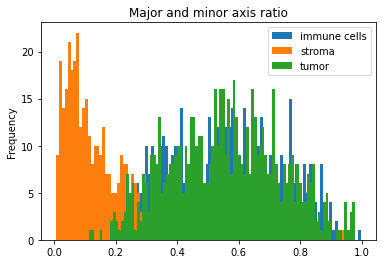

In [5]:
# Exploring major and minor axis
# https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/

def major_minor_axis(mask):
    y, x = np.nonzero(mask)
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    v2, v1 = np.sort(evals)
    return v1, v2

df['major axis'] = df['mask'].apply(lambda x: major_minor_axis(x)[0])
df['minor axis'] = df['mask'].apply(lambda x: major_minor_axis(x)[1])
df['axis ratio'] = df['minor axis'] / df['major axis']
df.groupby('class')['axis ratio'].plot.hist(bins = 100)
plt.legend()
plt.title('Major and minor axis ratio')

Max size: 39643
Min size: 29


Text(0.5, 1.0, 'Sizes in pixels')

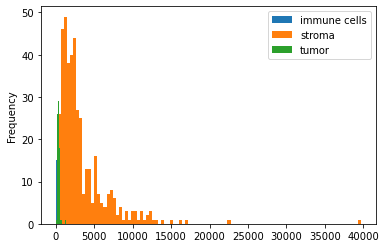

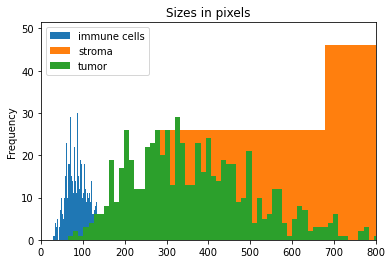

In [6]:
# Size Size varies between classes
print('Max size:', df['size'].max())
print('Min size:', df['size'].min())
plt.figure()
df.groupby('class')['size'].plot.hist(bins = 100)
plt.legend()
plt.figure()
df.groupby('class')['size'].plot.hist(bins = 100, xlim=(0, 800))
plt.legend()
plt.title('Sizes in pixels')

## Training basic model
We've found that the axis ratio and size seem to differ. We will use these as features.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import time

features = ['size', 'major axis', 'minor axis']
classes = ['tumor', 'stroma', 'immune cells']
df_class = pd.get_dummies(df['class'])
df_features = pd.concat([df_class, df[features]], axis=1)

np.random.seed(0) # Set random seed for test/train-split
msk = np.random.rand(len(df_features)) < 0.8
df_test = df_features[~msk]
df_train = df_features[msk]

X = df_train[features]
y = df_train[classes]

kf = KFold(n_splits=5,shuffle=True)
kf.split(X)

t = 1000 * time.time() # current time in milliseconds
np.random.seed(int(t) % 2**32)
cm_list = []
for train_index, val_index in kf.split(X):
    x_train, x_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_val).argmax(axis=1)
    y_val = y_val.values.argmax(axis=1)
    cm_list.append(confusion_matrix(y_val, y_pred, normalize='true'))


### Evaluation
The validation scores seem pretty promesing.

<AxesSubplot:>

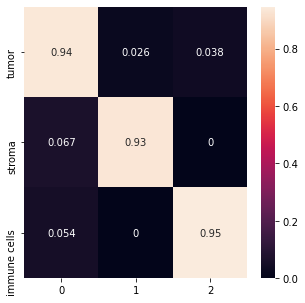

In [8]:
import seaborn as sn
df_cm = pd.DataFrame(np.mean(cm_list, axis=0), index = classes)
plt.figure(figsize=(5,5))
sn.heatmap(df_cm, annot=True)

## Classifying masks predicted by U-Net

In [9]:
def iou():
    pass

name = 'unet_monuseg_400'
model_dir = '../models/unet/'
print("Loading existing model...", end='')
model_unet = keras.models.load_model(f'{model_dir}/{name}.h5',
                    custom_objects={'my_loss' : my_loss, 'iou': iou})
print("Done!")

Loading existing model...WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
Done!


In [10]:
from tqdm import tqdm

def _reshape_to_batch(patch):
    n = int(np.sqrt(c.BATCH_SIZE))
    batch = []
    for col in np.array_split(patch,n, axis=0):
        for b in np.array_split(col,n, axis=1):
            batch.append(b)
    return np.asarray(batch)
            
def _reshape_to_patch(batch):
    n = int(np.sqrt(c.BATCH_SIZE))
    patch = np.zeros((n * c.HEIGHT, n * c.WIDTH))
    i = 0
    for y in range(0, n * c.HEIGHT, c.HEIGHT):
        for x in range(0, n * c.WIDTH, c.WIDTH):
            patch[y:y+c.HEIGHT, x:x+c.WIDTH]  = batch[i,...]
            i += 1
    return patch


In [ ]:
from skimage.transform import resize
from joblib import Memory

memory = Memory('./cache')

@memory.cache
def make_pred(im_id, model_name):
    model = keras.models.load_model(f'{model_dir}/{model_name}.h5',
                    custom_objects={'my_loss' : my_loss, 'iou': iou})
    img = Swebcg().load_image(im_id)
    scale = 2
    img = resize(img, (img.shape[0]*scale, img.shape[1]*scale)) * 255
    
    b_width = int(np.sqrt(c.BATCH_SIZE))
    stride = int(c.HEIGHT/2)
    pred = np.zeros(img.shape[0:2])
    norm_mat = np.ones_like(pred)
    for y in tqdm(range(0, pred.shape[1], stride)):
        for x in range(0, pred.shape[0], stride):
            img_patch = img[y:y + b_width * c.HEIGHT, x:x + b_width * c.WIDTH]
            batch_patch = np.zeros((b_width * c.HEIGHT, b_width * c.HEIGHT, c.CHANNELS))
            batch_patch[:img_patch.shape[0], :img_patch.shape[1]] = img_patch
            batch = _reshape_to_batch(batch_patch)
            pred_batch = model.predict(batch)[...,1]
            pred_patch = _reshape_to_patch(pred_batch)
            pred[y:y+ b_width * c.HEIGHT, x:x + b_width * c.WIDTH] += pred_patch[:img_patch.shape[0], :img_patch.shape[1]]
            norm_mat[y:y + b_width * c.HEIGHT, x:x + b_width * c.WIDTH] += 1
    
    pred = pred / norm_mat
    return resize(pred, (int(img.shape[0]/scale), int(img.shape[1]/scale)))

predictions = {}
for im_id in df["image_id"].unique():
    predictions[im_id] = make_pred(im_id, 'unet_monuseg_400')

________________________________________________________________________________
[Memory] Calling __main__--tank-data-arvid-SweBCG91RT-Net-notebooks-__ipython-input__.make_pred...
make_pred('TNBC_Block_5_E6_HE', 'unet_monuseg_400')


100%|██████████| 51/51 [04:38<00:00,  5.46s/it]


______________________________________________________make_pred - 286.3s, 4.8min
________________________________________________________________________________
[Memory] Calling __main__--tank-data-arvid-SweBCG91RT-Net-notebooks-__ipython-input__.make_pred...
make_pred('TNBC_Block_5_F5_HE', 'unet_monuseg_400')


100%|██████████| 51/51 [04:23<00:00,  5.17s/it]


______________________________________________________make_pred - 271.4s, 4.5min
________________________________________________________________________________
[Memory] Calling __main__--tank-data-arvid-SweBCG91RT-Net-notebooks-__ipython-input__.make_pred...
make_pred('TNBC_Block_5_G4_HE', 'unet_monuseg_400')


100%|██████████| 51/51 [04:24<00:00,  5.18s/it]


______________________________________________________make_pred - 272.4s, 4.5min
________________________________________________________________________________
[Memory] Calling __main__--tank-data-arvid-SweBCG91RT-Net-notebooks-__ipython-input__.make_pred...
make_pred('TNBC_Block_5_G5_HE', 'unet_monuseg_400')


100%|██████████| 51/51 [04:25<00:00,  5.20s/it]


______________________________________________________make_pred - 273.5s, 4.6min
________________________________________________________________________________
[Memory] Calling __main__--tank-data-arvid-SweBCG91RT-Net-notebooks-__ipython-input__.make_pred...
make_pred('TNBC_Block_5_H2_HE', 'unet_monuseg_400')


100%|██████████| 51/51 [04:24<00:00,  5.18s/it]


______________________________________________________make_pred - 272.5s, 4.5min
________________________________________________________________________________
[Memory] Calling __main__--tank-data-arvid-SweBCG91RT-Net-notebooks-__ipython-input__.make_pred...
make_pred('TNBC_Block_5_H8_HE', 'unet_monuseg_400')


 12%|█▏        | 6/51 [00:32<04:03,  5.41s/it]

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(pred)
plt.colorbar()

In [ ]:
from scipy.ndimage import find_objects
from skimage import measure
from skimage import segmentation
from skimage import morphology

# TODO
#labels = segmentation.random_walker(mask, pred[~mask])

def post_processing(prediction, p = [0.4, 30, 30]):
    prediction = (prediction > p[0])
    prediction = morphology.remove_small_holes(prediction, area_threshold=p[1])
    prediction = morphology.remove_small_objects(prediction, min_size=p[2])
    prediction = morphology.dilation(prediction, morphology.square(2))
    return prediction

def get_objects(mask):
    all_labels = measure.label(mask, background=0)
    return find_objects(all_labels)

for obj in random.choices(get_objects(mask), k=1):
    plt.figure()
    plt.subplot(131)
    plt.imshow(img[obj])
    plt.subplot(132)
    plt.imshow(pred[obj])
    plt.subplot(132)
    plt.imshow(mask[obj])
    
df_pred = pd.DataFrame([{"mask" : np.array(mask[obj], dtype=np.int),
                        "obj" : obj} for obj in get_objects(mask)])

In [ ]:
df_pred['size'] = df_pred['mask'].apply(np.sum)
df_pred['major axis'] = df_pred['mask'].apply(lambda x: major_minor_axis(x)[0])
df_pred['minor axis'] = df_pred['mask'].apply(lambda x: major_minor_axis(x)[1])
df_pred['axis ratio'] = df_pred['minor axis'] / df_pred['major axis']

X = df_pred[features]

def one_hot_to_class(arr):
    try:
        return classes[np.where(arr == 1)[0][0]]
    except:
        return "none"

def class_to_one_hot(cell_type):
    oh = np.array([0,0,0])
    oh[classes.index(cell_type)] = 1
    return oh
    
df_pred["class"] = [one_hot_to_class(k) for k in model.predict(X.iloc[:])]
df_pred["class"].value_counts()

In [ ]:
def _bbox_to_slice(bbox):
    return (slice(int(bbox[0][1]), int(bbox[1][1]), None), 
            slice(int(bbox[0][0]), int(bbox[1][0]), None))

# Dropping all data not from img
df = df[df["image_id"] == Swebcg().ids[0]]
df["obj"] = df["vertices"].apply(lambda x: _bbox_to_slice(utils.bounding_box(x)))

cm_list_unet = []
for cell_type, box in df[["class", "obj"]].iloc:
    m = mask[box]
    pred = model.predict([[np.sum(mask), *major_minor_axis(mask)]])
    cm_list_unet.append((cell_type, one_hot_to_class(pred[0])))
    
cm = confusion_matrix(*zip(*cm_list_unet), normalize='true')
df_cm_unet = pd.DataFrame(cm, index = classes)
plt.figure(figsize=(5,5))
sn.heatmap(df_cm_unet, annot=True)

In [ ]:
2 * (1, 2)